# ALGORITMO PARA IDENTIFICACIÓN SERIES DE ARMÓNICOS EN UN ESPECTRO DADO

El objetivo de este programa es identificar las series de armónicos más importantes de un espectro de frecuencias dado.

El esquema principal de este script es:
* Importar el fichero de datos de un espectro de frecuencias (en formato csv)
    * Modificar el espectro si éste tiene ski-slope
* Detectar picos e incertidumbres de los mismos:
    * Detección de picos con la función *encontrar_picos*
    * Funciones auxiliares creadas: *_peak_prominences*, *_peak_widths*
    * Cálculo de las incertidumbres
* Interpolación del espectro para estimar y corregir la localización de los picos
    * Función utilizada: *peak_estimator* con tipo de ventana: 'hann' o 'rect'
* Recalcular la incertidumbre de los picos
* Guardar todos los datos de picos e incertidumbres en un DataFrame
* Algoritmo principal de detección de series de armónicos
    * Introducción al algoritmo
    * Funciones auxiliares
    * Detección de series de armónicos
    * Criterios de clasificación de las series encontradas
    * Resultados obtenidos

In [1]:
from functions import encontrar_picos, _peak_prominences, _peak_widths, peak_estimator

## Importar los datos de un espectro de frecuencias

array([[3.125000e+00, 6.970920e-01],
       [4.687500e+00, 6.532500e-01],
       [6.250000e+00, 7.628560e-01],
       ...,
       [4.995313e+03, 1.439000e-03],
       [4.996875e+03, 8.610000e-04],
       [4.998438e+03, 1.147000e-03]])

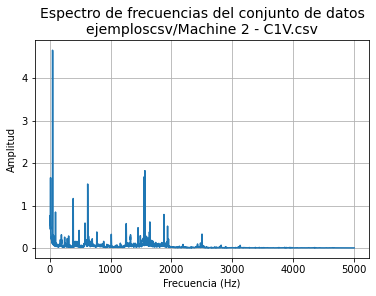

In [2]:
#### CARGAR DOCUMENTO CSV ####

datos = 'ejemploscsv/Machine 2 - C1V.csv'

import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt(datos, delimiter=',', skiprows=1) #separador decimales: .
                                                    #separador columnas: ,
                                                    #skiprows: cuantas lineas iniciales me salto
# Mostramos los datos
display(data)
frecuencias = data[:,0]
amplitudes = data[:,1]

# Mostramos la gráfica
plt.plot(frecuencias, amplitudes)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Espectro de frecuencias del conjunto de datos\n'+datos, fontsize='14')
plt.grid()

### Modificar el espectro si éste tiene ski-slope

Modificamos la señal transformando los primeros *nceros* valores a 0.

*Nota: para modificar el espectro también existe otra técnica que es integrar la señal.*

In [3]:
# Modificar la variable nceros para eliminar el "ski-slope"
"""
nceros = 100
amplitudes[0:100] = [0]*nceros

plt.plot(frecuencias, amplitudes)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.title('Espectro de frecuencias del conjunto de datos\n'+datos, fontsize='14')
"""

"\nnceros = 100\namplitudes[0:100] = [0]*nceros\n\nplt.plot(frecuencias, amplitudes)\nplt.xlabel('Frecuencia (Hz)')\nplt.ylabel('Amplitud')\nplt.title('Espectro de frecuencias del conjunto de datos\n'+datos, fontsize='14')\n"

## Detección de picos e incertidumbre de los mismos

In [4]:
s = np.std(amplitudes) #calculo la desviacion tipica de las amplitudes

#### MODIFICAR LOS SIGUIENTES PARÁMETROS PARA LA DETECCION DE PICOS E INCERTIDUMBRES

altura_pico = s          # Minima altura para detectar un pico en la gráfica
altura_relativa = 0.75   # Altura relativa a la cual se mide la anchura del pico (en porcentaje con respecto a su prominencia)
                         # 1 significa que se mide desde la base del pico.
prominencia = None       # Prominencia: Desnivel mínimo que hay que descender desde la cima de un pico para ascender a otro, cualquiera que sea, más alto.


###### Detección de los picos

Artículo de Medium "Algorithmic Thinking and Peak Finding": 
https://rabingaire.medium.com/algorithmic-thinking-peak-finding-ad6f7415d154

In [5]:
peaks = encontrar_picos(amplitudes, altura_pico)
print("Se han detectado", len(peaks), "picos. Con los siguientes indices:", peaks) #cuantos picos hay detectados

Se han detectado 55 picos. Con los siguientes indices: [2, 8, 15, 19, 22, 29, 36, 39, 50, 60, 111, 122, 126, 156, 184, 198, 246, 266, 308, 370, 376, 379, 398, 403, 407, 415, 431, 446, 494, 566, 646, 799, 803, 846, 848, 927, 951, 958, 982, 985, 989, 999, 1006, 1015, 1030, 1032, 1040, 1046, 1051, 1069, 1082, 1199, 1237, 1247, 1599]


###### Funciones  de la librería scipy.signal para encontrar las incertidumbres

Para encontrar los intervalos de incertidumbre alrededor de todos los picos detectados, se van a utilizar algunas de las funciones ya creadas de la librería *scipy*. La idea es imitar el funcionamiento de la función [*peak_widths*](https://github.com/scipy/scipy/blob/v1.8.0/scipy/signal/_peak_finding.py#L462-L587).

Para ello, se han transcrito y modificado ligeramente las funciones [*_peak_prominences*  y *_peak_widths*](https://github.com/scipy/scipy/blob/main/scipy/signal/_peak_finding_utils.pyx).

##### Cálculo de las incertidumbres
Calculamos las prominencias, anchuras y extremos izquierdo y derecho de las incertidumbres con la ayuda de las funciones auxiliares anteriores.

In [6]:
prominences, left_bases, right_bases = _peak_prominences(amplitudes, peaks, 1)
widths, width_heights, left_ips, right_ips = _peak_widths(amplitudes, peaks, altura_relativa, prominences, left_bases, right_bases)

# Calculamos los valores de frecuencia (Hz) de los extremos izquierdos y derechos de las incertidumbres de cada pico
left_cotas = []
right_cotas = []

for p in range(len(peaks)):
    entera_l = int(left_ips[p])
    decimal_l = left_ips[p] - entera_l
    entera_r = int(right_ips[p])
    decimal_r = right_ips[p] - entera_r
    
    left_cotas.append((frecuencias[entera_l+1]-frecuencias[entera_l])*decimal_l + frecuencias[entera_l])
    right_cotas.append((frecuencias[entera_r+1]-frecuencias[entera_r])*decimal_r + frecuencias[entera_r])
    
# Calculamos los valores de incertidumbre en términos de valores de frecuencia (Hz)
widths_new = np.array(right_cotas) - np.array(left_cotas)
widths = widths_new.copy()

Se han detectado 55 picos con los siguientes indices: [2, 8, 15, 19, 22, 29, 36, 39, 50, 60, 111, 122, 126, 156, 184, 198, 246, 266, 308, 370, 376, 379, 398, 403, 407, 415, 431, 446, 494, 566, 646, 799, 803, 846, 848, 927, 951, 958, 982, 985, 989, 999, 1006, 1015, 1030, 1032, 1040, 1046, 1051, 1069, 1082, 1199, 1237, 1247, 1599]

Los picos corresponden a las siguientes frecuencias:  [   6.25     15.625    26.5625   32.8125   37.5      48.4375   59.375
   64.0625   81.25     96.875   176.5625  193.75    200.      246.875
  290.625   312.5     387.5     418.75    484.375   581.25    590.625
  595.3125  625.      632.8125  639.0625  651.5625  676.5625  700.
  775.      887.5    1012.5    1251.563  1257.813  1325.     1328.125
 1451.563  1489.063  1500.     1537.5    1542.188  1548.438  1564.063
 1575.     1589.063  1612.5    1615.625  1628.125  1637.5    1645.313
 1673.438  1693.75   1876.563  1935.938  1951.563  2501.563 ]

A estos picos se les asocia los siguientes 55 valores de incerti

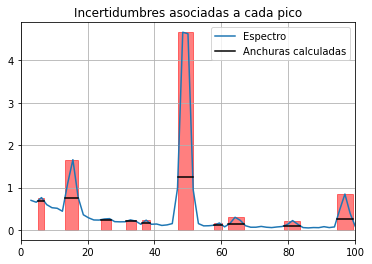

In [7]:
# Resumen y gráfica
print("Se han detectado", len(peaks), "picos con los siguientes indices:", peaks)
print("\nLos picos corresponden a las siguientes frecuencias: ", frecuencias[peaks])
print("\nA estos picos se les asocia los siguientes", len(widths), "valores de incertidumbre:", widths)

## Graficar las incertidumbres de cada pico
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.plot(frecuencias, amplitudes)
# añadimos las anchuras
for p in range(len(peaks)):
    ax.add_patch(Rectangle((left_cotas[p], 0), widths[p], amplitudes[peaks][p], color="red", alpha=0.5))
    x1 = left_cotas[p]
    x2 = right_cotas[p]
    y1 = y2 = width_heights[p]
    ax.plot([x1, x2], [y1, y2], color="black")

# mostramos el gráfico
plt.title('Incertidumbres asociadas a cada pico')
plt.legend(['Espectro', 'Anchuras calculadas'])
plt.xlim([0,100])
plt.grid()
plt.show()

## Interpolación del espectro para estimar y corregir la localización de los picos

Función utilizada: *peak_estimator* con tipo de ventana: 'hann' o 'rect'

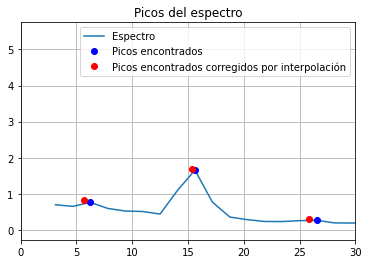

In [8]:
# Interpolación del espectro para corregir la localización de los picos
peaks_x = []
peaks_y = []

for p in peaks:
    try:
        x, y = peak_estimator(frecuencias[p-1:p+2], amplitudes[p-1:p+2], win='hann')
        peaks_x.append(x)
        peaks_y.append(y)
        
    except ValueError:
        print("Error en pico", p, ". Intervalo:", (frecuencias[p-1:p+2], amplitudes[p-1:p+2]))
        

# mostrar los resultados
plt.plot(frecuencias, amplitudes)
plt.plot(frecuencias[peaks], amplitudes[peaks], 'bo')
plt.plot(peaks_x, peaks_y, 'ro')
plt.title('Picos del espectro')
plt.legend(['Espectro', 'Picos encontrados', 'Picos encontrados corregidos por interpolación'])
plt.xlim([0,30])
plt.grid()

In [9]:
# Cambiamos los valores del espectro por los estimados
frecuencias_new = frecuencias.copy()
frecuencias_new[peaks] = peaks_x
amplitudes_new = amplitudes.copy()
amplitudes_new[peaks] = peaks_y

## Recalcular la incertidumbre de los picos

In [10]:
# Recalcular la anchura o incertidumbre de los nuevos picos
prominences_new, left_bases_new, right_bases_new = _peak_prominences(amplitudes_new, peaks, 1)
widths_new, width_heights_new, left_ips_new, right_ips_new = _peak_widths(amplitudes_new, peaks, altura_relativa, prominences_new, left_bases_new, right_bases_new)

# Calculamos los valores de frecuencia (Hz) de los extremos izquierdos y derechos de las incertidumbres de cada pico
left_cotas_new = []
right_cotas_new = []

for p in range(len(peaks)):
    entera_l = int(left_ips_new[p])
    decimal_l = left_ips_new[p] - entera_l
    entera_r = int(right_ips_new[p])
    decimal_r = right_ips_new[p] - entera_r
    
    left_cotas_new.append((frecuencias[entera_l+1]-frecuencias[entera_l])*decimal_l + frecuencias[entera_l])
    right_cotas_new.append((frecuencias[entera_r+1]-frecuencias[entera_r])*decimal_r + frecuencias[entera_r])
    
# Calculamos los valores de incertidumbre en términos de valores de frecuencia (Hz)
widths_new = np.array(right_cotas_new) - np.array(left_cotas_new)

Se han detectado 55 picos con los siguientes indices: [2, 8, 15, 19, 22, 29, 36, 39, 50, 60, 111, 122, 126, 156, 184, 198, 246, 266, 308, 370, 376, 379, 398, 403, 407, 415, 431, 446, 494, 566, 646, 799, 803, 846, 848, 927, 951, 958, 982, 985, 989, 999, 1006, 1015, 1030, 1032, 1040, 1046, 1051, 1069, 1082, 1199, 1237, 1247, 1599]

Los picos corresponden a las siguientes frecuencias:  [   5.65015525   15.32145688   25.82047839   33.43750282   37.5
   49.20990562   59.04934942   64.51454372   81.44440462   96.75560545
  175.84898487  193.48176107  199.77758148  246.25501367  290.33203019
  312.77269648  387.06803479  419.43681009  483.87111808  580.64253673
  590.21464869  595.81368026  625.49019554  632.34049397  639.68485546
  651.84712038  677.34375     699.90266421  774.23245855  887.89142999
 1012.58280676 1250.99379777 1258.04821986 1325.42898368 1328.56616963
 1451.37448241 1489.53795744 1500.7815     1537.5        1541.64799394
 1548.20584489 1563.73982753 1574.56563212 1589.80105

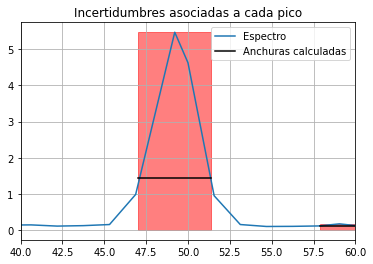

In [11]:
# Resumen y gráfica
print("Se han detectado", len(peaks), "picos con los siguientes indices:", peaks)
print("\nLos picos corresponden a las siguientes frecuencias: ", frecuencias_new[peaks])
print("\nA estos picos se les asocia los siguientes", len(widths_new), "valores de incertidumbre:", widths_new)

## Graficar las incertidumbres de cada pico
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.plot(frecuencias_new, amplitudes_new)
# añadimos las anchuras
for p in range(len(peaks)):
    ax.add_patch(Rectangle((left_cotas_new[p], 0), widths_new[p], amplitudes_new[peaks][p], color="red", alpha=0.5))
    x1 = left_cotas_new[p]
    x2 = right_cotas_new[p]
    y1 = y2 = width_heights_new[p]
    ax.plot([x1, x2], [y1, y2], color="black")

# mostramos el gráfico
plt.title('Incertidumbres asociadas a cada pico')
plt.legend(['Espectro', 'Anchuras calculadas'])
plt.xlim([40,60])
plt.grid()
plt.show()

## Guardar en un DataFrame los datos obtenidos de picos e incertidumbres

In [12]:
# Creamos el DataFrame con los datos de los picos obtenidos
import pandas as pd

datos_picos = {'Indice pico': peaks, 
               'Frecuencia dato (Hz)': frecuencias[peaks],
               'Frecuencia estimada (Hz)': frecuencias_new[peaks],
               'Anchura dato (Hz)': widths,
               'Anchura estimada (Hz)': widths_new,
               'Altura dato': amplitudes[peaks],
              'Altura estimada': amplitudes_new[peaks]}
df_picos = pd.DataFrame(datos_picos)
df_picos[0:20]

,Indice pico,Frecuencia dato (Hz),Frecuencia estimada (Hz),Anchura dato (Hz),Anchura estimada (Hz),Altura dato,Altura estimada
0,2,6.2500,5.650155,1.942846,2.069381,0.762856,0.839690
1,8,15.6250,15.321457,4.063700,4.000714,1.657238,1.698170
2,15,26.5625,25.820478,3.157391,2.729509,0.266342,0.308707
3,19,32.8125,33.437503,2.897138,2.726975,0.236748,0.262766
4,22,37.5000,37.500000,2.343750,2.343750,0.230172,0.231649
5,29,48.4375,49.209906,4.449055,4.312833,4.664819,5.475036
6,36,59.3750,59.049349,2.373451,2.361624,0.163313,0.167966
7,39,64.0625,64.514544,4.726800,4.590618,0.298128,0.314755
8,50,81.2500,81.444405,4.887140,4.857575,0.220307,0.222520
9,60,96.8750,96.755605,4.715879,4.708816,0.846156,0.849350


## Algoritmo principal de detección de series de armónicos

El algoritmo propuesto en este script ha sido obtenido del artículo científico: [*Identification of harmonics and sidebands in a finite set of spectral components*](https://hal.archives-ouvertes.fr/hal-00845120v2).

Timothée Gerber, Nadine Martin, Corinne Mailhes. Identification of harmonics and sidebands in a finite set of spectral components. The Tenth International Conference on Condition Monitoring and Machinery Failure Prevention Technologies (CM & MFPT 2013), Jun 2013, Krakow, Poland.
hal-00845120v2

### Introducción al algoritmo


*The context of our work takes place at the output of a spectral analysis tool which provides a set S of spectral components. Within this set, each component C<sub>i</sub> is characterized by at least its central frequency ν<sub>i</sub>, the uncertainty ∆ν<sub>i</sub> directly linked to the spectral resolution and its amplitude A<sub>i</sub>.\
S = {C<sub>1</sub> (v<sub>1</sub>, ∆ν<sub>1</sub>, A<sub>1</sub>), ..., C<sub>F</sub> (v<sub>F</sub>, ∆ν<sub>F</sub>, A<sub>F</sub>)} where F is the total number of spectral components detected.*

*The purpose of this study consists then in identifying the harmonic series and sidebands in the set S of detected spectral components.*\

*Harmonic series identification from estimated components is a nontrivial problem because of estimation errors. In fact, estimation errors do not preserve the accuracy of the relation between an estimated frequency and its harmonics. So, in order to find the harmonic frequency of order r of an estimated frequency ν<sub>i</sub>, looking for a detected component at a frequency exactly equal to r × ν<sub>i</sub> will not be sufficient.\
\
In this paper, we propose to use the uncertainty ∆ν<sub>i</sub> of each detected component to bypass the drawbacks of the non-exact frequency estimation. Each estimated frequency ν<sub>i</sub> is thus represented by a confidence interval of width ∆ν<sub>i</sub> centred on ν<sub>i</sub>. The harmonic detection is then completed by intersection of these intervals, as detailed in what follows.*

##################################################

Traducción al español:\
El contexto de nuestro trabajo tiene lugar en un conjunto S de componentes espectrales calculadas anteriormente.
Dentro de este conjunto, cada componente C<sub>i</sub> se caracteriza por su frecuencia central ν<sub>i</sub>, la incertidumbre ∆ν<sub>i</sub> que está directamente ligada con la resolución espectral y su amplitud A<sub>i</sub>.\
Es decir S = {C<sub>1</sub> (v<sub>1</sub>, ∆ν<sub>1</sub>, A<sub>1</sub>), ..., C<sub>F</sub> (v<sub>F</sub>, ∆ν<sub>F</sub>, A<sub>F</sub>)} donde F es el número total de componentes espectrales detectadas.

El propósito de este estudio consiste en identificar la series armónicas y las bandas laterales del conjunto S de componentes espectrales detectadas.

La identificación de series armónicas de componentes espectrales estimadas es un problema no trivial a causa de los errores de esstimación. De hecho, los errores de estimación no preservan la precisión de la relación entre la frecuencia estimada y sus armónicos. Así que para encontrar la frecuencia del armónico de orden r de una frecuencia estimada ν<sub>i</sub>, no basta con buscar la componente detectada de la frecuencia exacta r × ν<sub>i</sub>.\

En este paper, se propone usar la incertidumbre ∆ν<sub>i</sub> de cada componente con el objetivo de evitar los inconvenientes de la estimación "no exacta" de la frecuencia. Entonces, cada frecuncia estimada ν<sub>i</sub> estará representada por un intervalo de confianza de anchura ∆ν<sub>i</sub> centrada en ν<sub>i</sub>. Posteriormente la detección de armónicos se ejecutará intersecando estos intervalos. Más detalles posteriormente.

In [13]:
F = len(peaks)                     # F: numero de componentes detectadas en el espectro
v = frecuencias_new[peaks].copy()  # v: frecuencias de los picos
Dv = widths.copy()                 # Dv: incertidumbres asociadas a cada pico de frecuencia
A = amplitudes_new[peaks].copy()   # A: amplitudes asociadas a cada pico de frecuencia

print("Tenemos", F, "componentes espectrales estimadas.")
print("\nEstas componentes corresponden a las siguientes frecuencias: \n", v)

Tenemos 55 componentes espectrales estimadas.

Estas componentes corresponden a las siguientes frecuencias: 
 [   5.65015525   15.32145688   25.82047839   33.43750282   37.5
   49.20990562   59.04934942   64.51454372   81.44440462   96.75560545
  175.84898487  193.48176107  199.77758148  246.25501367  290.33203019
  312.77269648  387.06803479  419.43681009  483.87111808  580.64253673
  590.21464869  595.81368026  625.49019554  632.34049397  639.68485546
  651.84712038  677.34375     699.90266421  774.23245855  887.89142999
 1012.58280676 1250.99379777 1258.04821986 1325.42898368 1328.56616963
 1451.37448241 1489.53795744 1500.7815     1537.5        1541.64799394
 1548.20584489 1563.73982753 1574.56563212 1589.80105519 1612.98535068
 1614.91205541 1628.74313596 1638.21851359 1645.06636875 1672.8515984
 1693.17386234 1876.74804443 1935.42350374 1950.87776377 2502.21106313]


In [14]:
### PARAMETROS A MODIFICAR
orden_maximo = 10*F        # Maximo orden con el cual se calcula una frecuencia de la serie

criterio_parada = 5        # Numero maximo de veces que no se encuentra armonico, tras el cual
                           # el algoritmo deja de iterar (deja de buscar armonicos en la serie)    


#### Import the main functions

In [15]:
from functions import interseccion, intervalosarmonicos, encontrar_armonico, encontrar_seriearmonica

#### Programa principal

In [16]:
## Calcular los intervalos de cada componente i

intervalo_componente = []

for j in range(F): 
    j_liminf = v[j] - (Dv[j]/2)
    j_limsup = v[j] + (Dv[j]/2)
    intervalo_componente.append( [j_liminf, j_limsup] )

In [17]:
lista_series = []
lista_numero_armonicos = []

for i in range(F):
    output, indices, numero = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    
    lista_series.append(output)
    lista_numero_armonicos.append(numero)
    
    if numero > 1:
        print("\nLa serie armonica encontrada para la componente", i, "es:", output, "y se compone de", numero, "armonicos.")



La serie armonica encontrada para la componente 0 es: [5.403747893901415, 0, 15.321456881663607, 0, 25.820478393441686, 33.43750281593051, 37.5, 0, 49.209905616605575, 0, 59.04934941875985, 64.51454372441758, 0, 0, 81.44440461629709, 0, 0, 96.75560545082685] y se compone de 10 armonicos.

La serie armonica encontrada para la componente 1 es: [16.24805974064178, 33.43750281593051, 49.209905616605575, 64.51454372441758, 81.44440461629709, 96.75560545082685, 0, 0, 0, 0, 175.848984866943, 193.48176107462967, 0, 0, 246.25501366972114, 0, 0, 290.33203018931454] y se compone de 10 armonicos.

La serie armonica encontrada para la componente 2 es: [24.372089610962668, 49.209905616605575, 0, 96.75560545082685, 0, 0, 175.848984866943, 193.48176107462967, 0, 246.25501366972114, 0, 290.33203018931454, 0, 0, 0, 0, 419.43681008812825] y se compone de 8 armonicos.

La serie armonica encontrada para la componente 3 es: [32.324718076371475, 64.51454372441758, 96.75560545082685, 0, 0, 193.48176107462967

### Criterio de caracterización de las series

*The proposed method is exhaustive and identifies every harmonic series present in the spectrum. As a consequence, the number of series detected is large and some of them are not always relevant. Nevertheless, in the literature, there is no precise definition of a harmonic series (apart from a mathematical point of view). Moreover, the relevancy of a series depends on the application and the physical context of the studied signals. That is the reason why keeping all the series detected is necessary. Rather than eliminating the “false” series, the proposed method classifies the detected series thanks to the following three characterisation criteria.\
\
These criteria have been chosen as a comparison of each detected series to the corresponding “perfect” one. A “perfect” series is defined as a spectral comb going till the end of the spectrum with no harmonic missing.*

#########################################################################

Traducción al español:\
El método propuesto es exhaustivo e identifica todas las series armónicas presentes en el espectro. Como consecuencia, el número de series detectadas es muy grande y algunas de las series no son relevantes. Sin embargo, en la literatura, no hay una definición precisa de lo que es una serie armónica (aparte de la definición matemática). Además, la relevancia de cada serie depende de la aplicación o contexto físico de las señales estudiadas. Por esta razón, vamos a tener en cuenta todas las series detectadas. En vez de eliminar las series "incorrectas", el método propuesto clasifica las series detectadas gracias a unos criterios de caracterización.\

Estos criterios se han elegido como comparación de cada serie detectada a la serie "perfecta" correspondiente. Una serie "perfecta" se define como el peine de frecuencias que llega hasta el final del espectro y sin que le falte ningún armónico.


#### First criterion: density (D)

The first criterion denoted $D_i$, highlights the density of the series, in order to differentiate series with several harmonics missing from series with almost all harmonics present.

$D_i = \frac{\text{card}(H_i)}{r_i^{max}}$, with $r_i^{max}$ the rank of the last harmonic in the series $H_i$.

A series in which lots of harmonics are missing will have a small density whereas a "full" series including all harmonics will have a density equal to 1.

#### Primer criterio: densidad (D)

El primer criterio denotado como $D_i$ destaca la densidad de la serie, con el objetivo de diferenciar series a las cuales les faltan un número de armónicos con las series que están casi completas o completas.

$D_i = \frac{\text{card}(H_i)}{r_i^{max}}$, siendo $r_i^{max}$ el orden del último armónico encontrado en la serie $H_i$.

Una serie a la cual le faltan muchos armónicos tendrá una densidad pequeña mientras que una serie "completa" que incluya todos sus armónicos tendrá una densidad igual a 1.

In [18]:
lista_D = []

for i in range(F):
    serie, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    if numero_armonicos > 1:
        rmax = len(serie)
        H = 0
        for r in range(len(serie)):
            if (serie[r] != 0):
                H = H + 1
        D = H/rmax
    else:
        D = 0.0

    lista_D.append(D)

#### Second criterion: richness (R)

The second criterion is based on $N_i^{max}$ which is the maximum size of the series based on the frequency of its fundamental $ν_i$ and of the highest frequency $ν_F$ in the set S. This has to be compared to $r_i^{max}$ to define the second criterion, the richness $R_i$ of the series.

$R_i= \frac{r_i^{max}}{N_i^{max}}$ with $N_i^{max} = \text{int}(\frac{ν_F}{ν_i})$ with int( ) providing the integer part.

This will help to consider in a different way two series with the same cardinal and the same harmonic orders.

#### Segundo criterio: riqueza (R)

El segundo criterio se vasa en $N_i^{max}$ que es el tamaño máximo de la serie basado en su frecuencia fundamental $ν_i$ y en la frecuencia más alta $ν_F$ del conjunto S. Esto se compara con $r_i^{max}$ para definir este segundo criterio, la riqueza $R_i$ de la serie.

$R_i= \frac{r_i^{max}}{N_i^{max}}$ con $N_i^{max} = \text{int}(\frac{ν_F}{ν_i})$ siendo int( ) la parte entera.

Este criterio ayuda a considerar de manera diferente dos series con el mismo cardinal y los armónicos de los mismos órdenes.

In [19]:
lista_R = []

for i in range(F):
    serie, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    if numero_armonicos > 1:
        rmax = len(serie)
        Nmax = int(v[F-1]/serie[0])
    
        try:
            R = rmax/Nmax
        except ZeroDivisionError:
            R = 0.0   
    else: 
        R = 0.0

    lista_R.append(R)

##### Third criterion: Total Harmonic Distortion (THD)

$TDH = \frac{\sqrt{\sum \text{Power of harmonics}^2}}{\text{Power of fundamental frequency}} = \frac{\sqrt{\sum A_1^2 + ... + A_{N-1}^2}}{A_0}$, where $A_i$ is the amplitude or power of each harmonic detected $i=0,...N-1$ in the series, where $N$ is the total number of harmonics of the series.

This criterion will be helpful in applications where amplitude behaviour in harmonic series is known a priori and awaited.


##### Tercer criterio: Distorsión armónica total (THD)

$TDH = \frac{\sqrt{\sum \text{Potencia de los armónicos}^2}}{\text{Potencia de la frecuencia fundamental}} = \frac{\sqrt{\sum A_1^2 + ... + A_{N-1}^2}}{A_0}$, donde $A_i$ es la amplitud o potencia de cada componente $i=0,...N-1$ de la serie armónica, siendo $N$ el número de armónicos de dicha serie.

Este criterio es muy útil en aplicaciones donde se sabe la amplitud de la serie armónica a priori.

In [20]:
lista_THD = []

for i in range(F):
    serie, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    if numero_armonicos > 1:
        N = len(indices)
        THD = np.sqrt( sum(np.power(A[indices[1:N]], [2]*(N-1))) / (A[indices[0]]**2) )
    else:
        THD = 0.0

    lista_THD.append(THD)

#### Otro criterio que puede ser útil: número de armónicos encontrados de la serie

A desarrollar.

Este criterio también puede ser útil. El coeficiente NAS sería más alto cuántos más armónicos haya en la serie detectada.

In [21]:
lista_NAS = []

for i in range(F):
    serie, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    NAS = numero_armonicos
    lista_NAS.append(NAS)

#### Graficar las puntuaciones de los criterios para cada serie

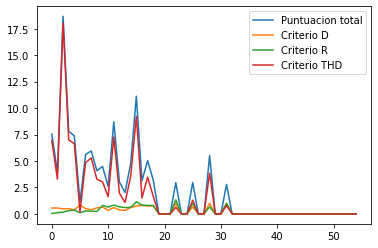

In [22]:
## Calculamos una PUNTUACION TOTAL para cada serie encontrada.
puntuacion = []
for j in range(F):
    puntuacion.append( lista_D[j] + lista_R[j] + lista_THD[j] ) #suma ponderada de puntuaciones de los criterios anteriores

plt.plot(range(F), puntuacion, range(F), lista_D, range(F), lista_R, range(F), lista_THD)
plt.legend(['Puntuacion total', 'Criterio D', 'Criterio R', 'Criterio THD'])

In [23]:
## Ordenar las series con las puntuaciones más altas a las más bajas
import pandas as pd

N = 20 #cuantas series queremos mostrar

df = pd.DataFrame([range(F), puntuacion])
df = df.transpose()
df.columns = ['Indice Serie','Puntuacion']
lista = df.nlargest(N, 'Puntuacion')['Indice Serie'] #las N series con puntuaciones más altas
lista = [int(k) for k in list(lista)]
display(df)
display(lista)

,Indice Serie,Puntuacion
0,0.0,7.536155
1,1.0,3.961556
2,2.0,18.676259
3,3.0,7.813927
4,4.0,7.375699
5,5.0,1.129371
6,6.0,5.625727
7,7.0,5.942597
8,8.0,4.081039
9,9.0,4.486957


[2, 15, 11, 3, 0, 4, 7, 6, 28, 17, 14, 9, 8, 1, 18, 16, 12, 25, 22, 31]

### Resultados obtenidos


Componente nº: 2
Frecuencia fundamental: 24.372089610962668
Puntuación: 18.67625854644866
No. miembros de la serie armónica: 8
Serie armónica encontrada: [24.372089610962668, 48.74417922192534, 0, 96.77117518690436, 0, 0, 174.95173690186468, 193.54235037380874, 0, 248.25632624055973, 0, 290.2748964811184, 0, 0, 0, 0, 418.65350391091374]


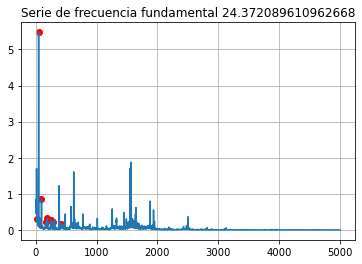

____________________________________________________________________________________________________________________

Componente nº: 15
Frecuencia fundamental: 312.7818465910811
Puntuación: 11.119407027478337
No. miembros de la serie armónica: 6
Serie armónica encontrada: [312.7818465910811, 625.5636931821622, 0, 1251.0890686820035, 1563.7398275332525, 1876.748044426766, 0, 2502.2110631308883]


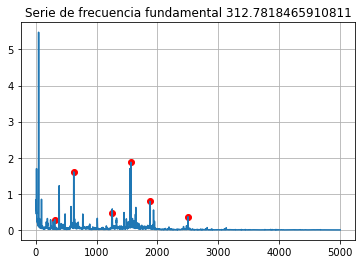

____________________________________________________________________________________________________________________

Componente nº: 11
Frecuencia fundamental: 193.54235037380874
Puntuación: 8.695500481058835
No. miembros de la serie armónica: 6
Serie armónica encontrada: [193.54235037380874, 387.0847007476175, 580.642536727567, 774.1029224430208, 0, 0, 0, 1548.2058448860416, 0, 1935.4235037380874]


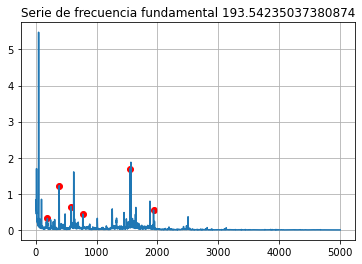

____________________________________________________________________________________________________________________

Componente nº: 3
Frecuencia fundamental: 32.32471807637147
Puntuación: 7.813926559332187
No. miembros de la serie armónica: 12
Serie armónica encontrada: [32.32471807637147, 62.77381732006802, 96.77117518690436, 0, 0, 193.54235037380874, 0, 0, 290.2748964811184, 0, 0, 387.0847007476175, 418.65350391091374, 0, 483.8558759345219, 0, 0, 580.642536727567, 0, 650.2925879226922, 677.34375, 0, 0, 774.1029224430208]


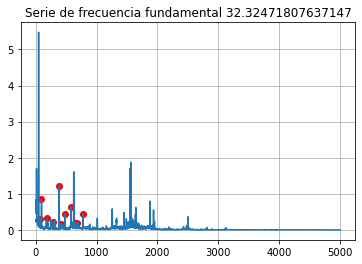

____________________________________________________________________________________________________________________

Componente nº: 0
Frecuencia fundamental: 5.403747893901415
Puntuación: 7.536155043893835
No. miembros de la serie armónica: 10
Serie armónica encontrada: [5.403747893901415, 0, 16.24805974064178, 0, 24.372089610962668, 32.32471807637147, 38.62324253128723, 0, 48.74417922192534, 0, 58.13977816333357, 62.77381732006802, 0, 0, 82.89580360512896, 0, 0, 96.77117518690436]


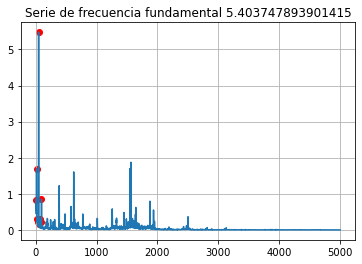

____________________________________________________________________________________________________________________

Componente nº: 4
Frecuencia fundamental: 38.62324253128723
Puntuación: 7.375699208151762
No. miembros de la serie armónica: 9
Serie armónica encontrada: [38.62324253128723, 0, 0, 0, 193.54235037380874, 0, 0, 0, 0, 387.0847007476175, 418.65350391091374, 0, 0, 0, 580.642536727567, 0, 650.2925879226922, 699.9026642102681, 0, 774.1029224430208, 0, 0, 887.8914299898835]


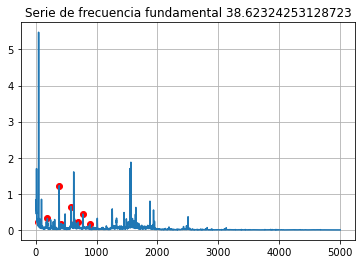

____________________________________________________________________________________________________________________

Componente nº: 7
Frecuencia fundamental: 62.77381732006802
Puntuación: 5.9425972814572505
No. miembros de la serie armónica: 4
Serie armónica encontrada: [62.77381732006802, 0, 193.54235037380874, 0, 312.7818465910811, 0, 0, 0, 0, 625.5636931821622]


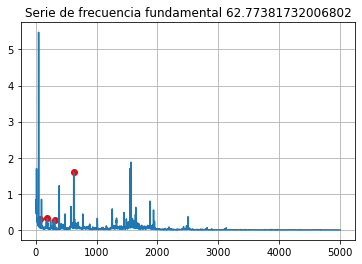

____________________________________________________________________________________________________________________

Componente nº: 6
Frecuencia fundamental: 58.13977816333357
Puntuación: 5.6257272916789915
No. miembros de la serie armónica: 6
Serie armónica encontrada: [58.13977816333357, 0, 174.95173690186468, 0, 290.2748964811184, 0, 0, 0, 0, 580.642536727567, 639.6848554574467, 699.9026642102681]


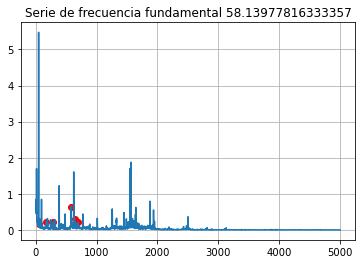

____________________________________________________________________________________________________________________

Componente nº: 28
Frecuencia fundamental: 774.1029224430208
Puntuación: 5.513431460276385
No. miembros de la serie armónica: 2
Serie armónica encontrada: [774.1029224430208, 1548.2058448860416]


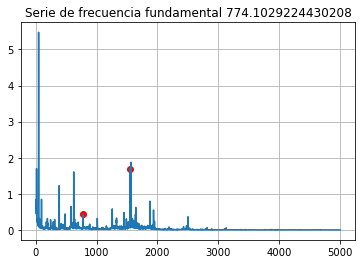

____________________________________________________________________________________________________________________

Componente nº: 17
Frecuencia fundamental: 418.65350391091374
Puntuación: 5.031992076251254
No. miembros de la serie armónica: 3
Serie armónica encontrada: [418.65350391091374, 0, 1258.0482198649922, 1672.8515984032156]


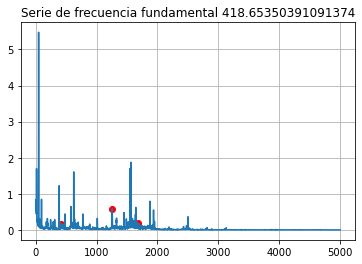

____________________________________________________________________________________________________________________

Componente nº: 14
Frecuencia fundamental: 290.2748964811184
Puntuación: 4.77509882811316
No. miembros de la serie armónica: 3
Serie armónica encontrada: [290.2748964811184, 580.642536727567, 0, 0, 1451.3744824055918]


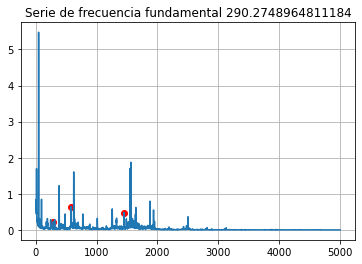

____________________________________________________________________________________________________________________

Componente nº: 9
Frecuencia fundamental: 96.77117518690436
Puntuación: 4.486956759354134
No. miembros de la serie armónica: 13
Serie armónica encontrada: [96.77117518690436, 193.54235037380874, 290.2748964811184, 387.0847007476175, 483.8558759345219, 580.642536727567, 677.34375, 774.1029224430208, 0, 0, 0, 0, 1258.0482198649922, 0, 1451.3744824055918, 1548.2058448860416, 1645.066368750025, 0, 0, 1935.4235037380874]


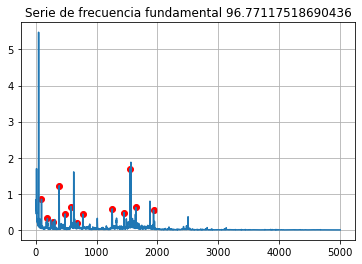

____________________________________________________________________________________________________________________

Componente nº: 8
Frecuencia fundamental: 82.89580360512896
Puntuación: 4.081038817413525
No. miembros de la serie armónica: 4
Serie armónica encontrada: [82.89580360512896, 0, 248.25632624055973, 0, 418.65350391091374, 0, 580.642536727567]


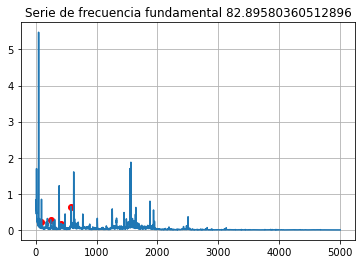

____________________________________________________________________________________________________________________

Componente nº: 1
Frecuencia fundamental: 16.24805974064178
Puntuación: 3.9615558613348165
No. miembros de la serie armónica: 10
Serie armónica encontrada: [16.24805974064178, 32.32471807637147, 48.74417922192534, 62.77381732006802, 82.89580360512896, 96.77117518690436, 0, 0, 0, 0, 174.95173690186468, 193.54235037380874, 0, 0, 248.25632624055973, 0, 0, 290.2748964811184]


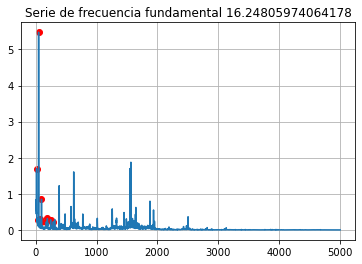

____________________________________________________________________________________________________________________

Componente nº: 18
Frecuencia fundamental: 483.8558759345219
Puntuación: 3.205158156076283
No. miembros de la serie armónica: 3
Serie armónica encontrada: [483.8558759345219, 0, 1451.3744824055918, 1935.4235037380874]


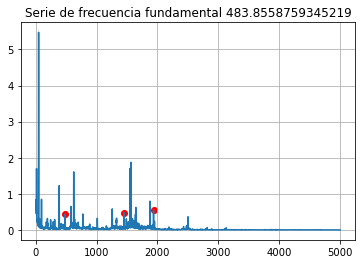

____________________________________________________________________________________________________________________

Componente nº: 16
Frecuencia fundamental: 387.0847007476175
Puntuación: 3.1350789608705285
No. miembros de la serie armónica: 4
Serie armónica encontrada: [387.0847007476175, 774.1029224430208, 0, 1548.2058448860416, 1935.4235037380874]


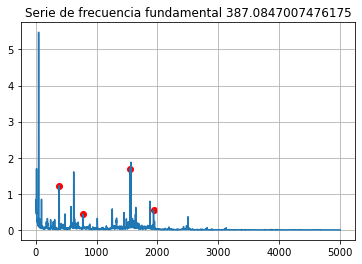

____________________________________________________________________________________________________________________

Componente nº: 12
Frecuencia fundamental: 198.84747278543932
Puntuación: 3.0060278210837477
No. miembros de la serie armónica: 3
Serie armónica encontrada: [198.84747278543932, 0, 595.8136802602813, 0, 0, 0, 0, 1589.801055187638]


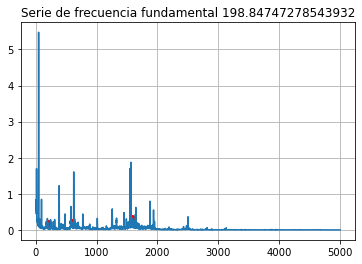

____________________________________________________________________________________________________________________

Componente nº: 25
Frecuencia fundamental: 650.2925879226922
Puntuación: 2.967187861558939
No. miembros de la serie armónica: 2
Serie armónica encontrada: [650.2925879226922, 0, 1950.8777637680764]


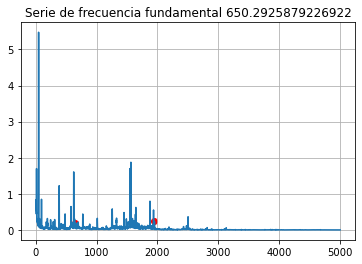

____________________________________________________________________________________________________________________

Componente nº: 22
Frecuencia fundamental: 625.5636931821622
Puntuación: 2.9492450111004502
No. miembros de la serie armónica: 4
Serie armónica encontrada: [625.5636931821622, 1251.0890686820035, 1876.748044426766, 2502.2110631308883]


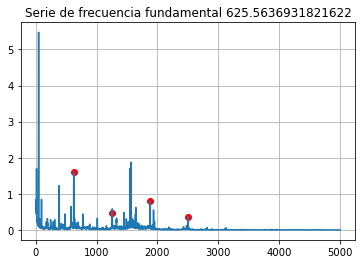

____________________________________________________________________________________________________________________

Componente nº: 31
Frecuencia fundamental: 1251.0890686820035
Puntuación: 2.792265436209738
No. miembros de la serie armónica: 2
Serie armónica encontrada: [1251.0890686820035, 2502.2110631308883]


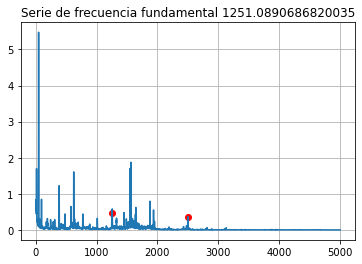

____________________________________________________________________________________________________________________


In [24]:
## Recopilamos toda la información
for i in lista:
    output, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    print("\nComponente nº:", i)
    print("Frecuencia fundamental:", output[0])
    print("Puntuación:", puntuacion[i])
    print("No. miembros de la serie armónica:", numero_armonicos)
    print("Serie armónica encontrada:", output)
    
    plt.plot(frecuencias_new, amplitudes_new)
    plt.scatter(frecuencias_new[np.array(peaks)[indices]], amplitudes_new[np.array(peaks)[indices]], color = 'r')
    plt.title("Serie de frecuencia fundamental " + str(output[0]))
    plt.grid()
    plt.show()
    print("____________________________________________________________________________________________________________________")

In [25]:
#Recopilamos toda la informacion en un data frame

datos_series = {'Componente': range(F), 
                'Frecuencia fundamental (Hz)': frecuencias_new[peaks], 
                'Serie armonica': lista_series,
                'Numero armonicos': lista_numero_armonicos,
                'Puntuacion total': puntuacion,
                'Criterio D': lista_D,
                'Criterio R': lista_R,
                'Criterio THD': lista_THD}
df_series = pd.DataFrame(datos_series)
df_series

,Componente,Frecuencia fundamental (Hz),Serie armonica,Numero armonicos,Puntuacion total,Criterio D,Criterio R,Criterio THD
0,0,5.650155,"[5.403747893901415, 0, 15.321456881663607, 0, ...",10,7.536155,0.555556,0.038877,6.941723
1,1,15.321457,"[16.24805974064178, 33.43750281593051, 49.2099...",10,3.961556,0.555556,0.116883,3.289117
2,2,25.820478,"[24.372089610962668, 49.209905616605575, 0, 96...",8,18.676259,0.470588,0.166667,18.039004
3,3,33.437503,"[32.324718076371475, 64.51454372441758, 96.755...",12,7.813927,0.500000,0.311688,7.002238
4,4,37.500000,"[38.62324253128723, 0, 0, 0, 193.4817610746296...",9,7.375699,0.391304,0.359375,6.625020
5,5,49.209906,"[48.74417922192534, 96.75560545082685, 0, 193....",5,1.129371,0.833333,0.117647,0.178390
6,6,59.049349,"[58.139778163333574, 0, 175.848984866943, 0, 2...",6,5.625727,0.500000,0.279070,4.846658
7,7,64.514544,"[62.77381732006802, 0, 193.48176107462967, 0, ...",4,5.942597,0.400000,0.256410,5.286187
8,8,81.444405,"[82.89580360512898, 0, 246.25501366972114, 0, ...",4,4.081039,0.571429,0.233333,3.276277
9,9,96.755605,"[96.77117518690437, 193.48176107462967, 290.33...",13,4.486957,0.650000,0.800000,3.036957


In [26]:
df_series.sort_values(by = 'Puntuacion total', ascending=False)[0:30]

,Componente,Frecuencia fundamental (Hz),Serie armonica,Numero armonicos,Puntuacion total,Criterio D,Criterio R,Criterio THD
2,2,25.820478,"[24.372089610962668, 49.209905616605575, 0, 96...",8,18.676259,0.470588,0.166667,18.039004
15,15,312.772696,"[312.7818465910811, 625.4901955417666, 0, 1250...",6,11.119407,0.750000,1.142857,9.226550
11,11,193.481761,"[193.54235037380874, 387.0680347916496, 580.64...",6,8.695500,0.600000,0.833333,7.262167
3,3,33.437503,"[32.324718076371475, 64.51454372441758, 96.755...",12,7.813927,0.500000,0.311688,7.002238
0,0,5.650155,"[5.403747893901415, 0, 15.321456881663607, 0, ...",10,7.536155,0.555556,0.038877,6.941723
4,4,37.500000,"[38.62324253128723, 0, 0, 0, 193.4817610746296...",9,7.375699,0.391304,0.359375,6.625020
7,7,64.514544,"[62.77381732006802, 0, 193.48176107462967, 0, ...",4,5.942597,0.400000,0.256410,5.286187
6,6,59.049349,"[58.139778163333574, 0, 175.848984866943, 0, 2...",6,5.625727,0.500000,0.279070,4.846658
28,28,774.232459,"[774.1029224430208, 1548.2058448860416]",2,5.513431,1.000000,0.666667,3.846765
17,17,419.436810,"[418.65350391091374, 0, 1258.0482198649922, 16...",3,5.031992,0.750000,0.800000,3.481992
